# Boston Dataset Analysis

Fits a Model to Boston Dataset (https://www.kaggle.com/c/boston-housing)

In [1]:
import timeit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.cross_validation import KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn import neighbors
from sklearn import svm
from sklearn import tree
from sklearn import ensemble
        
seed = 16

/usr/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Some Helpful Functions

# Calculate VIF and drop colinear variables
from statsmodels.stats.outliers_influence import variance_inflation_factor    
def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped=True
    while dropped:
        dropped=False
        vif = [variance_inflation_factor(X.iloc[:,variables].values, ix) for ix in range(X.iloc[:,variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:,variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:,variables]

def run_estimators(estimators, X_train, y_train, X_test, y_test, scoring, cv=5, verbose=False):

    scores = []
    
    for clf in estimators:
        print("Running {0}...".format(clf.__class__.__name__))
        start_time = timeit.default_timer()
        clf.fit(X_train, y_train)
        elapsed = timeit.default_timer() - start_time
        print('Time Elapsed: ' + str(elapsed))
                
        test_scores = cross_val_score(clf, X_test, y_test, scoring=scoring, cv=cv)
        mean_test_cv_score = np.mean(test_scores)
        std_def_test_cv_score = np.std(test_scores)
        
        if verbose:
            train_scores = cross_val_score(clf, X_train, y_train, scoring=scoring, cv=cv)
            print("Mean Train CV Score: {0}".format(np.mean(train_scores)))
            print("Std. Dev. Train CV Score: {0}".format(np.std(train_scores)))
            print("Mean Test CV Score: {0}".format(mean_test_cv_score))
            print("Std. Dev. Test CV Score: {0}".format(std_dev_test_cv_score))  
        
        scores.append((clf.__class__.__name__ + " " + str(clf.get_params()), mean_test_cv_score, std_def_test_cv_score))
        
    return sorted(scores, key=lambda x: x[1], reverse=True)
        
        
def get_oof(clf, x_train, y_train, x_test, n_folds=5, random_state=16):
    ntrain = X_train.shape[0]
    ntest = X_test.shape[0]
    
    kf = KFold(ntrain, n_folds=n_folds, random_state=random_state)
    
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((n_folds, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train.iloc[train_index]
        y_tr = y_train.iloc[train_index]
        x_te = x_train.iloc[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return pd.DataFrame(oof_train.reshape(-1, 1)), pd.DataFrame(oof_test.reshape(-1, 1))

def stack(estimators, X_train, y_train, X_test):
    stacked_X_train = pd.DataFrame()
    stacked_X_test = pd.DataFrame()
    
    cols = []
    
    for est in estimators:
        cols.append(est.__class__.__name__)
        est_oof_train, est_oof_test = get_oof(est, X_train, y_train, X_test)
        
        stacked_X_train = pd.concat([stacked_X_train, est_oof_train], axis=1)
        stacked_X_test = pd.concat([stacked_X_test, est_oof_test], axis=1)
        
    stacked_X_train.columns = cols
    stacked_X_test.columns = cols
    
    return stacked_X_train, stacked_X_test

In [3]:
# Load Boston Dataset
boston = datasets.load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['target'] = boston.target

In [4]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


## EDA

/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


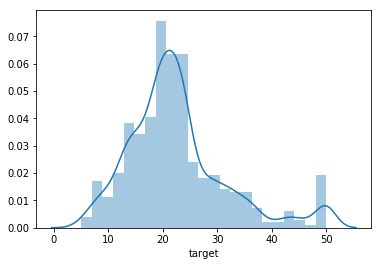

In [5]:
# Get a sense of our target variable (House prices in $1000's)

sns.distplot(df['target']);

Target variable is decidedly non-normal, but let's check anyways.

In [6]:
k2, p = stats.normaltest(df['target'])
alpha = 0.05
print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected. Not a Normal Distribution.")
else:
    print("The null hypothesis cannot be rejected. May be a Normal Distribution.")

p = 1.75832e-20
The null hypothesis can be rejected. Not a Normal Distribution.


In [7]:
print("Skewness: %f" % df['target'].skew())
print("Kurtosis: %f" % df['target'].kurt())

Skewness: 1.108098
Kurtosis: 1.495197


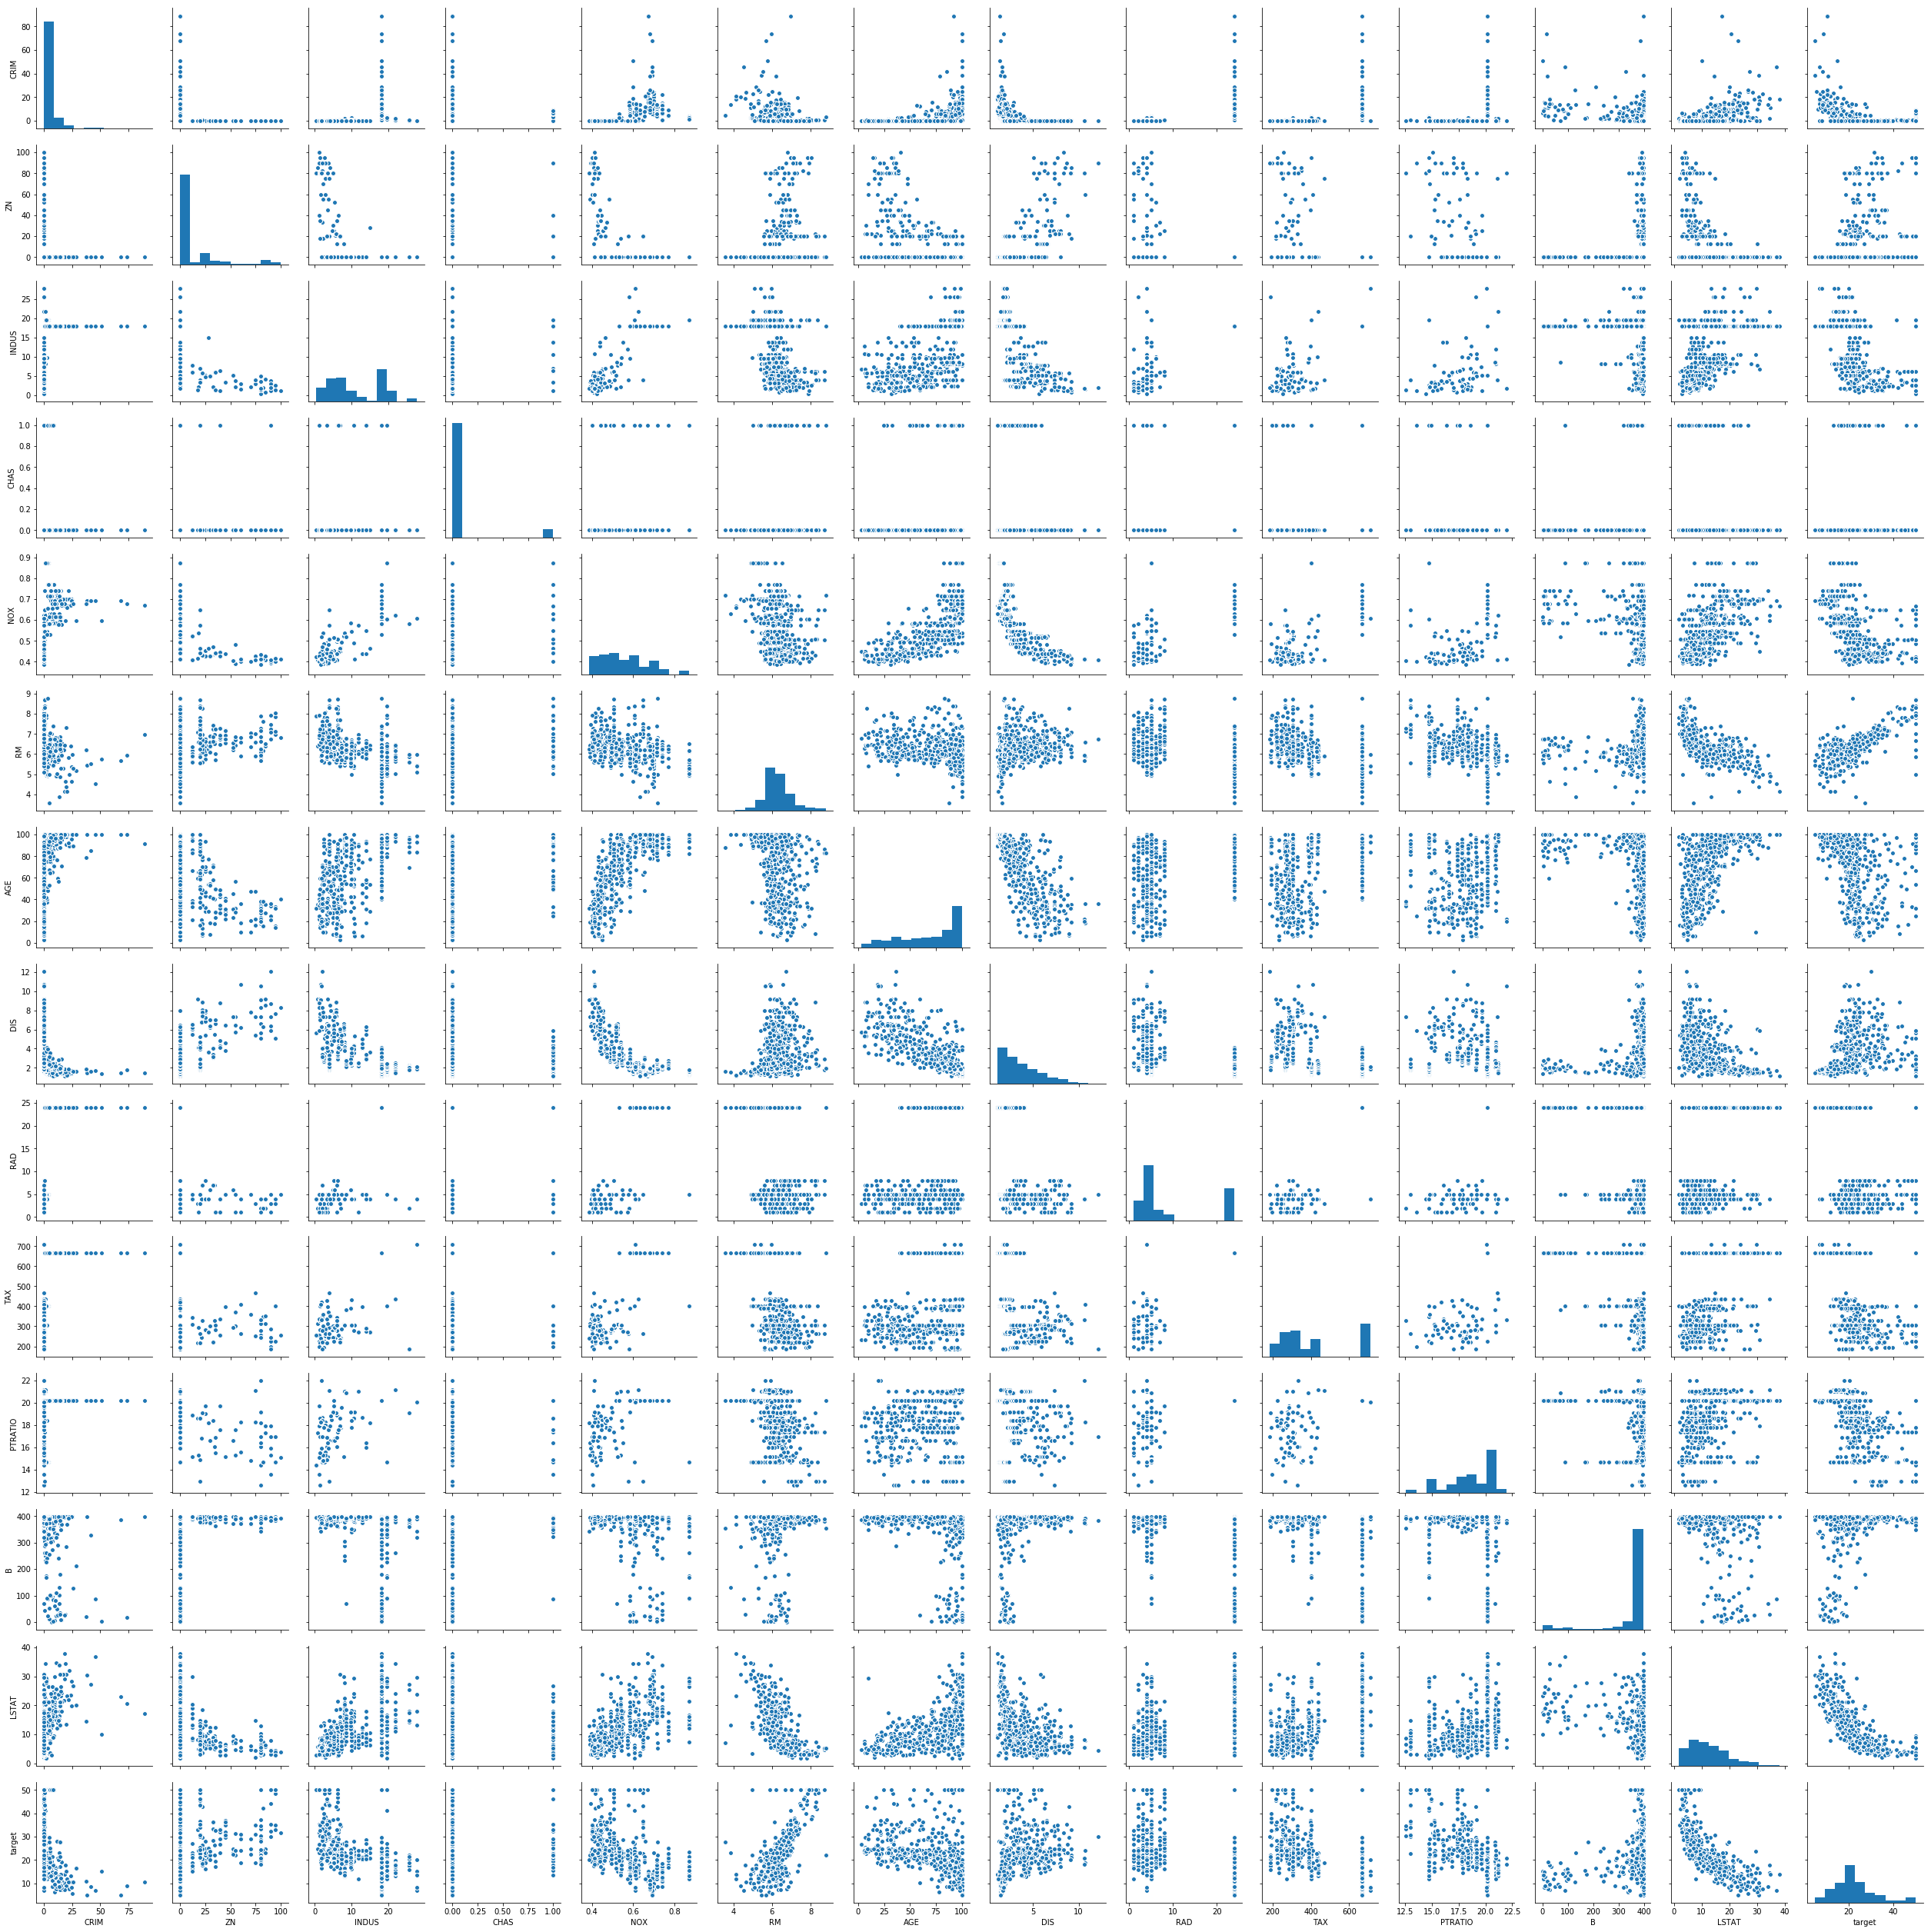

In [8]:
# Pair Plot
sns.pairplot(df)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6d9d8fc18>,
      dtype=object)

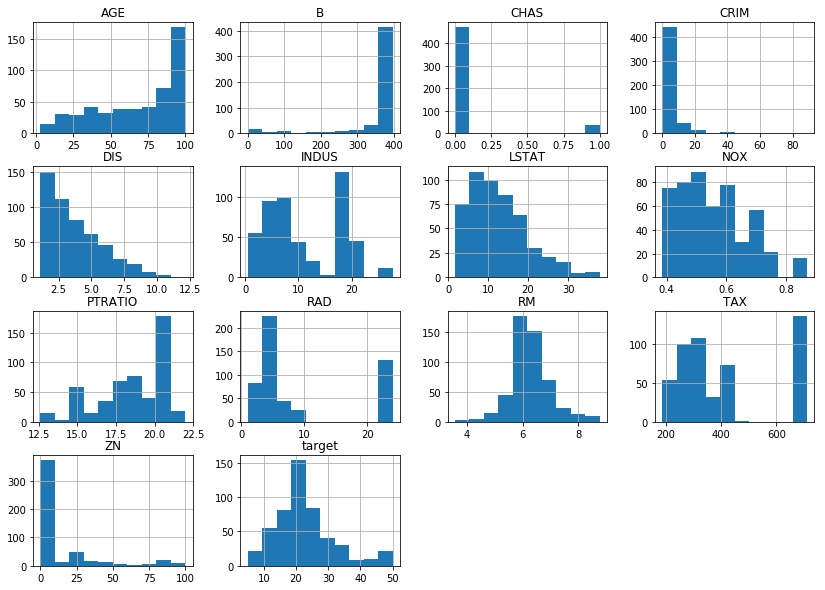

In [9]:
df.hist(figsize=(14,10))

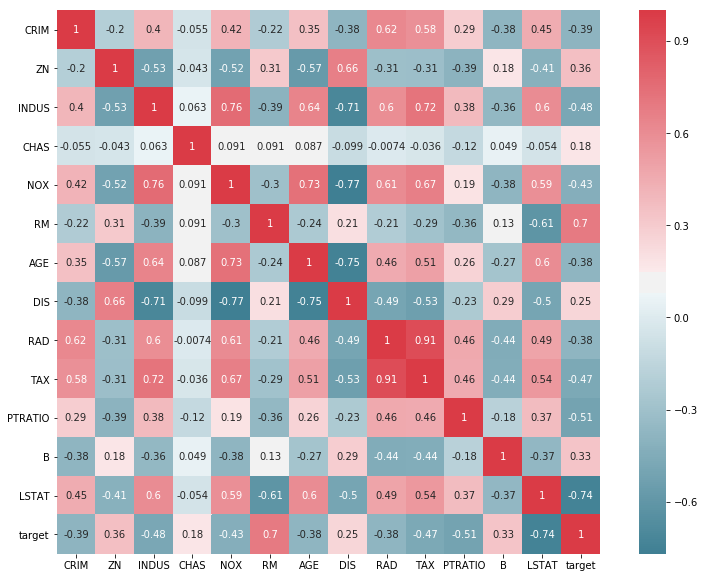

In [10]:
# Correlation Map

f, ax = plt.subplots(figsize=(14, 10))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)

In [11]:
# Detect Multicollinearity
# range from 0 (Perfect Collinearity) to 1 (No Collinearity)

# Compare the determinant
print(np.linalg.det(corr)) 

3.482819589959191e-05


## Data Correct and Clean

In [12]:
# Missing Values Check
# Generally throw away columns that are missing more than 15%

total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data)

         Total  Percent
target       0      0.0
LSTAT        0      0.0
B            0      0.0
PTRATIO      0      0.0
TAX          0      0.0
RAD          0      0.0
DIS          0      0.0
AGE          0      0.0
RM           0      0.0
NOX          0      0.0
CHAS         0      0.0
INDUS        0      0.0
ZN           0      0.0
CRIM         0      0.0


## Preprocess

In [13]:
y = df['target']
X = df.drop(['target'], axis=1)

In [14]:
# Standardize
# Standardization is required for L1 and L2 Regularization, SVMs, and PCA (More or less any algorithm based on distance)
col_names = X.columns
X = pd.DataFrame(StandardScaler().fit_transform(X), columns=col_names)

# Drop colinear Variables
X = calculate_vif_(X)
# Compare the determinant to previous
print(np.linalg.det(X.corr())) 

X.head()

dropping 'TAX' at index: 9
Remaining variables:
Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')
0.001209553581536344


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,PTRATIO,B,LSTAT
0,-0.417713,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-1.459000,0.441052,-1.075562
1,-0.415269,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.303094,0.441052,-0.492439
2,-0.415272,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.303094,0.396427,-1.208727
3,-0.414680,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,0.113032,0.416163,-1.361517
4,-0.410409,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,0.113032,0.441052,-1.026501


In [15]:
# Test, Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

## Model Selection

Start from simple to complex

Linear Models -> Support Vectors -> Trees -> Ensembles, Boosting, Bagging, Etc. -> Stacked Models

In [16]:
# Regression
clfs =[
    # Linear Models
    linear_model.LinearRegression(),
    linear_model.Ridge(random_state=seed),
    linear_model.BayesianRidge(),
    linear_model.Lasso(random_state=seed),
    linear_model.LassoLars(),
    linear_model.Lars(),
    linear_model.ElasticNet(random_state=seed),
    linear_model.ARDRegression(),
    linear_model.PassiveAggressiveRegressor(max_iter=1000, tol=1e-3, random_state=seed), # 0.21 defaults
    linear_model.RANSACRegressor(random_state=seed),
    linear_model.SGDRegressor(max_iter=1000, tol=1e-3, random_state=seed),  # 0.21 defaults
    linear_model.TheilSenRegressor(max_iter=1000, tol=1e-3, random_state=seed),  # 0.21 defaults
    # K-Neighbors
    neighbors.KNeighborsRegressor(n_neighbors = 1),
    neighbors.KNeighborsRegressor(n_neighbors = 2),
    neighbors.KNeighborsRegressor(n_neighbors = 4),
    neighbors.KNeighborsRegressor(n_neighbors = 8),
    neighbors.KNeighborsRegressor(n_neighbors = 16),
    neighbors.KNeighborsRegressor(n_neighbors = 32),
    neighbors.KNeighborsRegressor(n_neighbors = 64),
    # Support Vector Machines
    svm.LinearSVR(random_state=seed), #liblinear
    svm.NuSVR(),
    svm.SVR(kernel="linear"), #libsvm
    svm.SVR(kernel="sigmoid"),
    svm.SVR(kernel="rbf"),
    # Tree (CART)
    tree.DecisionTreeRegressor(random_state=seed),
    tree.ExtraTreeRegressor(random_state=seed),
    # Ensemble Methods
    ensemble.AdaBoostRegressor(random_state=seed),
    ensemble.BaggingRegressor(random_state=seed),
    ensemble.ExtraTreesRegressor(random_state=seed),
    ensemble.IsolationForest(random_state=seed),
    ensemble.GradientBoostingRegressor(random_state=seed),
    ensemble.RandomForestRegressor(random_state=seed)
    #TODO State of the art models - e.g. XGBoost
]

scores = run_estimators(clfs, X_train, y_train, X_test, y_test, scoring="neg_mean_squared_error")

print("\nBest Scores:")
for s in scores:
    print("{0}\n{1} (+/- {2})".format(s[0], s[1], s[2]))

Running LinearRegression...
Time Elapsed: 0.0009747569856699556
Running Ridge...
Time Elapsed: 0.0006058149883756414
Running BayesianRidge...
Time Elapsed: 0.00147425799514167
Running Lasso...
Time Elapsed: 0.0009573639981681481
Running LassoLars...
Time Elapsed: 0.0006854910025140271
Running Lars...
Time Elapsed: 0.002034755001659505
Running ElasticNet...
Time Elapsed: 0.0007371450046775863
Running ARDRegression...
Time Elapsed: 0.8431862129946239
Running PassiveAggressiveRegressor...
Time Elapsed: 0.0004983399994671345
Running RANSACRegressor...
Time Elapsed: 0.05685565200110432
Running SGDRegressor...
Time Elapsed: 0.0007652700005564839
Running TheilSenRegressor...
Time Elapsed: 1.0498670950037194
Running KNeighborsRegressor...
Time Elapsed: 0.0004008850082755089
Running KNeighborsRegressor...
Time Elapsed: 0.0004560020024655387
Running KNeighborsRegressor...
Time Elapsed: 0.0004497139889281243
Running KNeighborsRegressor...
Time Elapsed: 0.00037761899875476956
Running KNeighborsReg

In [30]:
# Look at feature importances of trees
# Importances > 0.1
# Extra Trees: RM, LSTAT
# Gradient Boosting: RM, LSTAT, DIS, INDUS, CRIM (Close .094)
# AdaBoost: LSTAT, RM, DIS
# Random Forest: RM, LSTAT

tr = ensemble.GradientBoostingRegressor(random_state=seed)
tr.fit(X_train, y_train)
fi_tr = sorted(list(zip(X_train.columns, tr.feature_importances_)), key=lambda x: x[1], reverse=True)

print(tr.__class__.__name__)
for fi in fi_tr:
    print("{0} - {1}".format(fi[0], fi[1]))

GradientBoostingRegressor
RM - 0.19964292615713697
LSTAT - 0.1649221557244488
DIS - 0.1604731095424343
INDUS - 0.10244454024493298
CRIM - 0.09444343864589304
B - 0.07926149706363693
AGE - 0.05869524951099789
PTRATIO - 0.058231352811093554
NOX - 0.040515805746050064
RAD - 0.01868417950237218
CHAS - 0.01806418873656667
ZN - 0.004621556314436638


### Tune Best Models

We tune ExtraTrees and GradientBoosting.

In [18]:
et = ensemble.ExtraTreesRegressor()

param_grid = { 
           "n_estimators" : [9, 18, 27, 36, 45, 54, 63],
           "max_depth" : [1, 5, 10, 15, 20, 25, 30],
           "min_samples_leaf" : [1, 2, 4, 6, 8, 10]}
clf = GridSearchCV(et, param_grid,cv=5, scoring="neg_mean_squared_error")
clf.fit(X_train, y_train)

print("Best parameters set found on train set:")
print()
print(clf.best_params_)
print()
print("Grid scores on train set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Best parameters set found on train set:

{'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 63}

Grid scores on train set:

-50.716 (+/-29.114) for {'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 9}
-50.725 (+/-21.156) for {'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 18}
-48.363 (+/-27.332) for {'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 27}
-50.661 (+/-24.560) for {'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 36}
-50.919 (+/-27.701) for {'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 45}
-47.529 (+/-26.687) for {'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 54}
-49.426 (+/-26.884) for {'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 63}
-54.324 (+/-26.364) for {'max_depth': 1, 'min_samples_leaf': 2, 'n_estimators': 9}
-52.735 (+/-29.461) for {'max_depth': 1, 'min_samples_leaf': 2, 'n_estimators': 18}
-50.292 (+/-25.799) for {'max_depth': 1, 'min_samples_leaf': 2, 'n_estimators': 27}
-50.277 (+/-38.358) for {'max_de

In [19]:
gb = ensemble.GradientBoostingRegressor()

param_grid = { 
           "n_estimators" : [100, 150, 200, 300, 500, 1000],
           "min_samples_leaf" : [1, 2, 4, 6, 8, 10]}
clf = GridSearchCV(gb, param_grid,cv=5, scoring="neg_mean_squared_error")
clf.fit(X_train, y_train)

print("Best parameters set found on train set:")
print()
print(clf.best_params_)
print()
print("Grid scores on train set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Best parameters set found on train set:

{'min_samples_leaf': 4, 'n_estimators': 100}

Grid scores on train set:

-14.434 (+/-16.540) for {'min_samples_leaf': 1, 'n_estimators': 100}
-13.791 (+/-14.404) for {'min_samples_leaf': 1, 'n_estimators': 150}
-14.766 (+/-17.185) for {'min_samples_leaf': 1, 'n_estimators': 200}
-14.036 (+/-15.041) for {'min_samples_leaf': 1, 'n_estimators': 300}
-14.867 (+/-16.261) for {'min_samples_leaf': 1, 'n_estimators': 500}
-14.275 (+/-15.281) for {'min_samples_leaf': 1, 'n_estimators': 1000}
-14.874 (+/-17.638) for {'min_samples_leaf': 2, 'n_estimators': 100}
-15.103 (+/-19.569) for {'min_samples_leaf': 2, 'n_estimators': 150}
-14.955 (+/-17.658) for {'min_samples_leaf': 2, 'n_estimators': 200}
-15.092 (+/-17.660) for {'min_samples_leaf': 2, 'n_estimators': 300}
-15.706 (+/-19.747) for {'min_samples_leaf': 2, 'n_estimators': 500}
-14.990 (+/-16.653) for {'min_samples_leaf': 2, 'n_estimators': 1000}
-12.714 (+/-8.278) for {'min_samples_leaf': 4, 'n_estima

## Ensemble Stack Models

In [29]:
clfs = [
    ensemble.ExtraTreesRegressor(max_depth=15, min_samples_leaf=1, n_estimators=27, random_state=seed),
    ensemble.GradientBoostingRegressor(min_samples_leaf=4, n_estimators=100, random_state=seed),
]

X_train_2, X_test_2 = stack(clfs, X_train, y_train, X_test)

stacker = linear_model.LinearRegression()
stacker.fit(X_train_2, y_train)
scores = np.sqrt(cross_val_score(stacker, X_test_2, y_test, scoring='neg_mean_squared_error', cv=5) * -1)

print("Mean RMSE: {0}, Std. Dev. RMSE: {1}".format(np.mean(scores), np.std(scores)))

Mean RMSE: 2.914339342376028, Std. Dev. RMSE: 0.29496043966262714


In [21]:
# Test Stacked for best model

# Regression
clfs =[
    # Linear Models
    linear_model.LinearRegression(),
    linear_model.Ridge(random_state=seed),
    linear_model.BayesianRidge(),
    linear_model.Lasso(random_state=seed),
    linear_model.LassoLars(),
    linear_model.Lars(),
    linear_model.ElasticNet(random_state=seed),
    linear_model.ARDRegression(),
    linear_model.PassiveAggressiveRegressor(max_iter=1000, tol=1e-3, random_state=seed), # 0.21 defaults
    linear_model.RANSACRegressor(random_state=seed),
    linear_model.SGDRegressor(max_iter=1000, tol=1e-3, random_state=seed),  # 0.21 defaults
    linear_model.TheilSenRegressor(max_iter=1000, tol=1e-3, random_state=seed),  # 0.21 defaults
    # K-Neighbors
    neighbors.KNeighborsRegressor(n_neighbors = 1),
    neighbors.KNeighborsRegressor(n_neighbors = 2),
    neighbors.KNeighborsRegressor(n_neighbors = 4),
    neighbors.KNeighborsRegressor(n_neighbors = 8),
    neighbors.KNeighborsRegressor(n_neighbors = 16),
    neighbors.KNeighborsRegressor(n_neighbors = 32),
    neighbors.KNeighborsRegressor(n_neighbors = 64),
    # Support Vector Machines
    svm.LinearSVR(random_state=seed), #liblinear
    svm.NuSVR(),
    svm.SVR(kernel="linear"), #libsvm
    svm.SVR(kernel="sigmoid"),
    svm.SVR(kernel="rbf"),
    # Tree (CART)
    tree.DecisionTreeRegressor(random_state=seed),
    tree.ExtraTreeRegressor(random_state=seed),
    # Ensemble Methods
    ensemble.AdaBoostRegressor(random_state=seed),
    ensemble.BaggingRegressor(random_state=seed),
    ensemble.ExtraTreesRegressor(random_state=seed),
    ensemble.IsolationForest(random_state=seed),
    ensemble.GradientBoostingRegressor(random_state=seed),
    ensemble.RandomForestRegressor(random_state=seed)
    #TODO State of the art models - e.g. XGBoost
]

scores = run_estimators(clfs, X_train_2, y_train, X_test_2, y_test, scoring="neg_mean_squared_error")

print("\nBest Scores:")
for s in scores:
    print("{0}\n{1} (+/- {2})".format(s[0], s[1], s[2]))

Running LinearRegression...
Time Elapsed: 0.0006137320015113801
Running Ridge...
Time Elapsed: 0.0011749020050046965
Running BayesianRidge...
Time Elapsed: 0.0007956299959914759
Running Lasso...
Time Elapsed: 0.0006029890064382926
Running LassoLars...
Time Elapsed: 0.0005157479899935424
Running Lars...
Time Elapsed: 0.0006908389914315194
Running ElasticNet...
Time Elapsed: 0.0005218550068093464
Running ARDRegression...
Time Elapsed: 0.15830722999817226
Running PassiveAggressiveRegressor...
Time Elapsed: 0.0003941220056731254
Running RANSACRegressor...
Time Elapsed: 0.004273799990187399
Running SGDRegressor...
Time Elapsed: 0.0006906409980729222
Running TheilSenRegressor...
Time Elapsed: 0.39018592800130136
Running KNeighborsRegressor...
Time Elapsed: 0.00043981600902043283
Running KNeighborsRegressor...
Time Elapsed: 0.00021787300647702068
Running KNeighborsRegressor...
Time Elapsed: 0.00023389099806081504
Running KNeighborsRegressor...
Time Elapsed: 0.00021511399245355278
Running KNei

In [22]:
stacker = linear_model.TheilSenRegressor(max_iter=1000, tol=1e-3, random_state=seed)
stacker.fit(X_train_2, y_train)
scores = np.sqrt(cross_val_score(stacker, X_test_2, y_test, scoring='neg_mean_squared_error', cv=5) * -1)
y_pred = cross_val_predict(stacker, X_test_2, y_test, cv=5)

print("Mean RMSE: {0}, Std. Dev. RMSE: {1}".format(np.mean(scores), np.std(scores)))

Mean RMSE: 2.8914852765283023, Std. Dev. RMSE: 0.28174888366169787


In [23]:
X_train_2.head()

,ExtraTreesRegressor,GradientBoostingRegressor
0,44.974074,44.293893
1,19.702346,20.441244
2,15.385185,14.707521
3,30.503086,30.236689
4,20.984568,21.193589


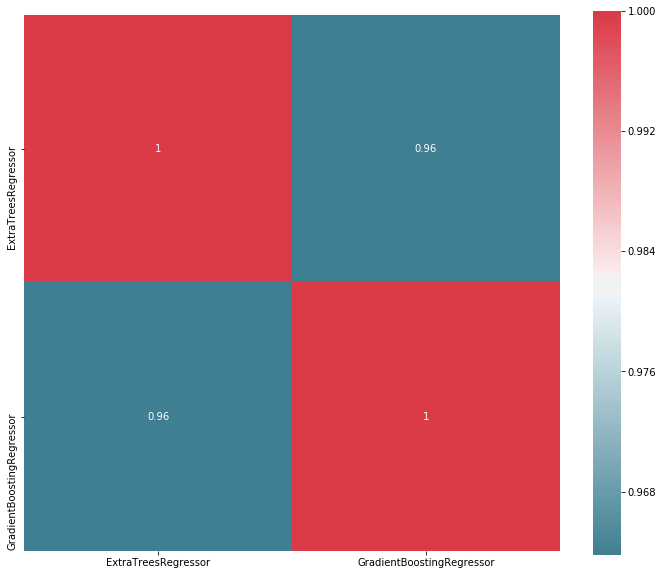

In [24]:
f, ax = plt.subplots(figsize=(12, 10))
corr = X_train_2.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)

There have been quite a few articles and Kaggle competition winner stories about the merits of having trained models that are more uncorrelated with one another producing better scores.

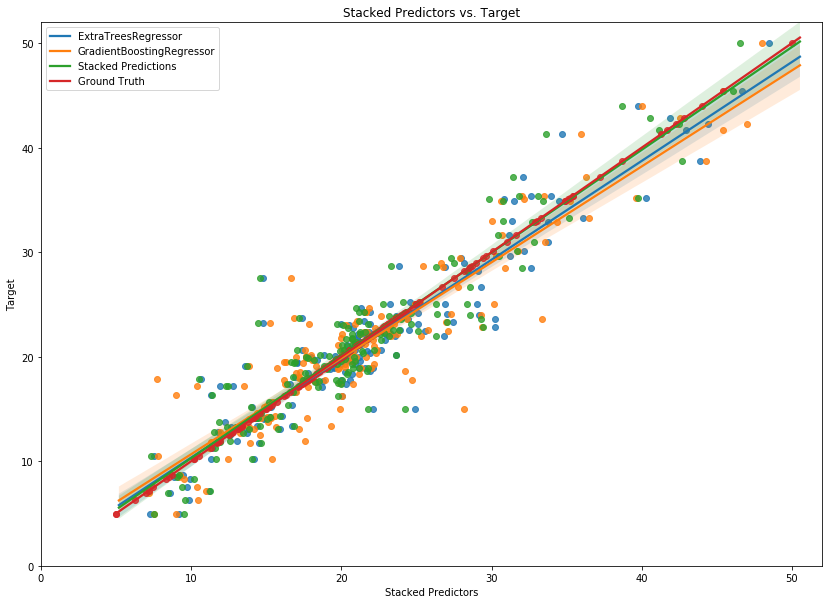

In [25]:
plt.figure(figsize=(14,10))

sns.regplot(x=X_test_2['ExtraTreesRegressor'], y=y_test)
sns.regplot(x=X_test_2['GradientBoostingRegressor'], y=y_test)
sns.regplot(x=y_pred, y=y_test) # Stacked Predictions
ax = sns.regplot(x=y_test, y=y_test) # Ground Truth

cols = list(X_test_2.columns)
cols.append("Stacked Predictions")
cols.append("Ground Truth")

ax.set(xlabel='Stacked Predictors', ylabel='Target', title='Stacked Predictors vs. Target')
ax.legend(cols)
plt.ylim(0, 52)
plt.xlim(0, 52)
plt.show()

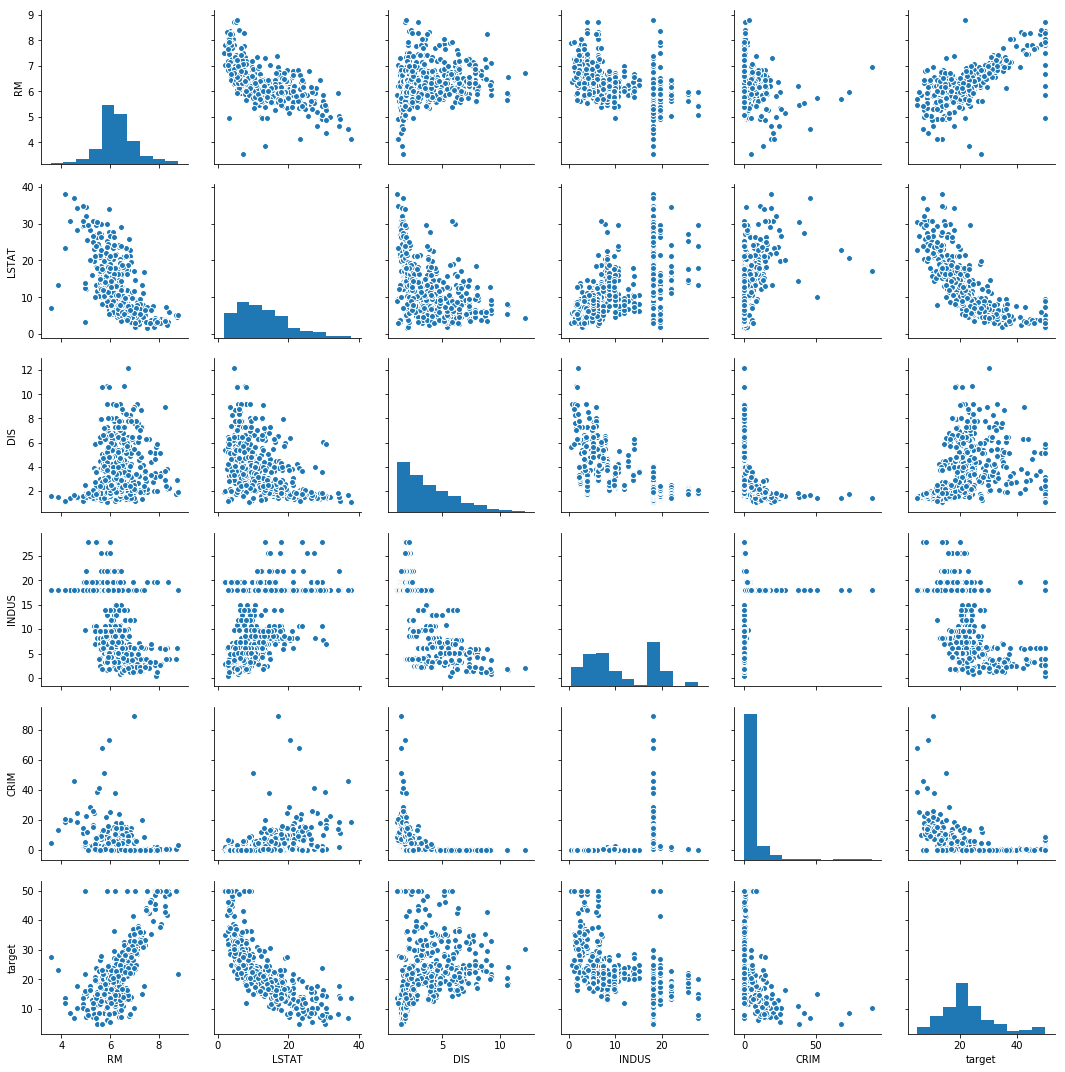

In [32]:
# Let's do a little inference in important features from Gradient Boosting

sns.pairplot(df[['RM', 'LSTAT', 'DIS', 'INDUS', 'CRIM', 'target']])